In [210]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## 0. 학습 준비
- 데이터셋 로드
- 환경 설정 (패키지 설치 및 로드)

In [237]:
import os

# === 입출력 경로 ===
os.environ.setdefault("CSV_PATH", "labeled_sentences_voted_every_data.csv")   # seed 파일 경로

# 배치 단위 (한 번에 몇 개의 항목을 생성시킬지)
os.environ.setdefault("BATCH_SIZE", "10")

# 생성 다양성
os.environ.setdefault("TEMPERATURE", "0.8")
os.environ.setdefault("TOP_P", "0.9")

print("환경설정 완료")


환경설정 완료


In [238]:

# 환경 설정과 데이터 로드
import re, random, json, types
import numpy as np
import pandas as pd
from pathlib import Path

CSV_PATH = os.getenv("CSV_PATH")

df = pd.read_csv(CSV_PATH)
df_daily = pd.read_csv(CSV_PATH)
df_biz = pd.read_csv("schedule_dataset_augmented_epoch_2.csv")

print("Loaded shape:", df_daily.shape)
print("Loaded shape:", df_biz.shape)
display(df_daily.head())
display(df_biz.head())

Loaded shape: (50000, 6)
Loaded shape: (2000, 8)


,file_path,sentence,label_pred,agree_rate,certainty_avg,accept
0,test/TS_4.tourism.zip/04.레저/tourism4_1596.txt,전화받았습니다 #@소속#입니다,0,1.0,83,True
1,test/TS_2.civil_complaint.zip/04.민원신고/civil co...,그것도 해주시고 다 해주세요 왜냐면 저도 이제 몇 번을 참은 거라서요,0,1.0,75,True
2,test/TS_2.civil_complaint.zip/04.민원신고/civil co...,네 다른 건의사항 있으십니까,0,1.0,85,True
3,test/TS_3.education.zip/03.비용환불문의/education3_0...,아 그래요 #@기타#문고나 #@기타#문고에도 없어요,0,1.0,76,True
4,test/TS_1.shopping.zip/02.제품사용문의/shopping2_221...,감사합니다 고객님 #@소속# 고객센터였습니다,0,1.0,100,True


,sentence,domain,task,label,confidence,source,seed_id,epoch
0,배경 러프 수정본 여기 있어요,design_production,NONE,0,0.99,teacher,0.0,0
1,오늘 밤에 색감 체크 가능하신가요?,design_production,CREATE,1,0.92,teacher,1.0,0
2,싱크표 다시 올려드릴게요,design_production,NONE,0,0.98,teacher,2.0,0
3,금요일 오후 킥오프 미팅 할까요?,design_production,CREATE,1,0.95,teacher,3.0,0
4,오늘 콘티 피드백만 주세요,design_production,NONE,0,0.97,teacher,4.0,0


In [239]:
df_daily = df_daily.drop(columns=["file_path"])
df_biz = df_biz[df_biz["label"] != 0]
df_daily = df_daily.rename(columns={"label_pred": "label"})

In [240]:
df_daily['domain'] = 'daily'
df_biz['domain'] = 'biz'
df = pd.concat([df_daily, df_biz], ignore_index=True)
display(df)

,sentence,label,agree_rate,certainty_avg,accept,domain,task,confidence,source,seed_id,epoch
0,전화받았습니다 #@소속#입니다,0,1.0,83.0,True,daily,NaN,NaN,NaN,NaN,NaN
1,그것도 해주시고 다 해주세요 왜냐면 저도 이제 몇 번을 참은 거라서요,0,1.0,75.0,True,daily,NaN,NaN,NaN,NaN,NaN
2,네 다른 건의사항 있으십니까,0,1.0,85.0,True,daily,NaN,NaN,NaN,NaN,NaN
3,아 그래요 #@기타#문고나 #@기타#문고에도 없어요,0,1.0,76.0,True,daily,NaN,NaN,NaN,NaN,NaN
4,감사합니다 고객님 #@소속# 고객센터였습니다,0,1.0,100.0,True,daily,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
51255,"다음 주 미팅, 월요일로 옮기기로 했어. 14시로 정했어.",1,NaN,NaN,NaN,biz,UPDATE,0.97,augmented,NaN,3.0
51256,싱크 끝나면 바로 잉킹 리뷰 시작해볼게 😎,1,NaN,NaN,NaN,biz,CREATE,0.99,augmented,NaN,3.0
51257,오늘 1시 채색팀 시간 맞아? 혹시 15분 늦춰도 괜찮아?,1,NaN,NaN,NaN,biz,INFO,0.96,augmented,NaN,3.0
51258,내일 바빠서 채색 세션 못 하겠어... 뭐 할까? 혹시 다른 시간이 있나요?,1,NaN,NaN,NaN,biz,CANCEL,0.94,augmented,NaN,3.0


In [241]:
df['label'].value_counts(normalize=True)

label
0    0.918533
1    0.081467
Name: proportion, dtype: float64

In [242]:
 
# 텍스트/라벨 컬럼 자동 감지 및 분할
from sklearn.model_selection import train_test_split

text_col = "sentence" if "sentence" in df.columns else df.columns[0]
label_col = "label" if "label" in df.columns else df.columns[-1]
domain_col = "domain"
print("Using columns -> text:", text_col, "label:", label_col)

df = df[[text_col, label_col, domain_col]].dropna().reset_index(drop=True)
X = df[text_col].astype(str).values
y = df[label_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=38, stratify=y
)
len(X_train), len(X_test)
display(df)

Using columns -> text: sentence label: label


,sentence,label,domain
0,전화받았습니다 #@소속#입니다,0,daily
1,그것도 해주시고 다 해주세요 왜냐면 저도 이제 몇 번을 참은 거라서요,0,daily
2,네 다른 건의사항 있으십니까,0,daily
3,아 그래요 #@기타#문고나 #@기타#문고에도 없어요,0,daily
4,감사합니다 고객님 #@소속# 고객센터였습니다,0,daily
...,...,...,...
51255,"다음 주 미팅, 월요일로 옮기기로 했어. 14시로 정했어.",1,biz
51256,싱크 끝나면 바로 잉킹 리뷰 시작해볼게 😎,1,biz
51257,오늘 1시 채색팀 시간 맞아? 혹시 15분 늦춰도 괜찮아?,1,biz
51258,내일 바빠서 채색 세션 못 하겠어... 뭐 할까? 혹시 다른 시간이 있나요?,1,biz


## TF-IDF 분류기

In [243]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# 1) char ngram 기반
tfidf_char = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(2,5), min_df=3)),
    ("clf", LinearSVC(class_weight="balanced"))
])
tfidf_char.fit(X_train, y_train)
pred_char = tfidf_char.predict(X_test)
acc_char = accuracy_score(y_test, pred_char)
print("TF‑IDF char Accuracy:", acc_char)
print(classification_report(y_test, pred_char))

# 2) word 기반
tfidf_word = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="word", token_pattern=r"(?u)\b\w+\b", min_df=3)),
    ("clf", LinearSVC(class_weight="balanced"))
])
tfidf_word.fit(X_train, y_train)
pred_word = tfidf_word.predict(X_test)
acc_word = accuracy_score(y_test, pred_word)
print("TF‑IDF word Accuracy:", acc_word)
print(classification_report(y_test, pred_word))

TF‑IDF char Accuracy: 0.9709325009754194
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9417
           1       0.81      0.84      0.82       835

    accuracy                           0.97     10252
   macro avg       0.90      0.91      0.90     10252
weighted avg       0.97      0.97      0.97     10252

TF‑IDF word Accuracy: 0.9397190792040577
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      9417
           1       0.60      0.79      0.68       835

    accuracy                           0.94     10252
   macro avg       0.79      0.87      0.82     10252
weighted avg       0.95      0.94      0.94     10252



### 업무 항목에 대한 가중치 조정

In [244]:
# import numpy as np

# w = np.ones(len(df))
# w[(df['domain'] == 'biz') & (df['label'] == 1)] = 2  # 3배로 가중치

In [245]:
# tfidf_char.fit(df['sentence'], df['label'], clf__sample_weight=w)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [289]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, d_train, d_val = train_test_split(
    df['sentence'], df['label'], df['domain'],
    test_size=0.2, random_state=42, stratify=df['label']
)

In [336]:
import numpy as np

tfidf_char.set_params(clf__class_weight="balanced")  # 이미 설정했으면 생략
w = np.ones(len(X_train), float)
w[(d_train=="biz") & (y_train==1)] = 2.5  # 2~3배로 시작 추천

tfidf_char.fit(X_train, y_train, clf__sample_weight=w)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [323]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

scores = tfidf_char.decision_function(X_val)  # 연속 점수
ap = average_precision_score(y_val, scores)
print("average_precision:", ap)

prec, rec, thr = precision_recall_curve(y_val, scores)  # scores=decision_function
print("precision min~max:", prec[:-1].min(), prec[:-1].max())
target_p = 0.9  # 목표 정밀도
ok = np.where(prec[:-1] >= target_p)[0]
best_idx = ok[np.argmax(rec[ok])] if len(ok) else np.argmax(rec)
best_thr = thr[best_idx]

y_pred = (scores >= best_thr).astype(int)

average_precision: 0.8886855710641062
precision min~max: 0.0814475224346469 1.0


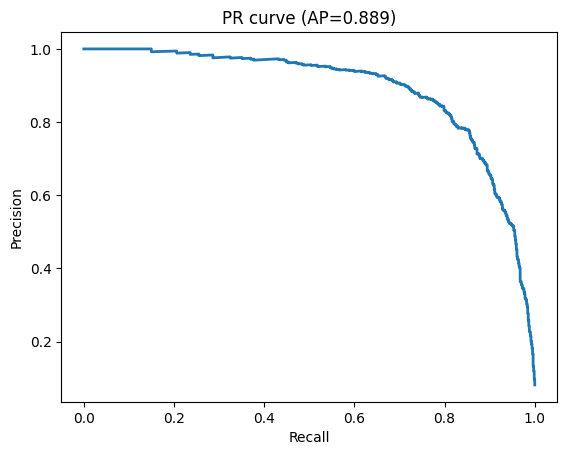

In [324]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_val, scores)  # scores=decision_function
ap = average_precision_score(y_val, scores)

plt.figure()
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR curve (AP={ap:.3f})")
plt.show()

In [325]:
def find_thr_for_precision(y, scores, target_p=0.9):
    prec, rec, thr = precision_recall_curve(y, scores)
    idx_ok = np.where(prec[:-1] >= target_p)[0]
    
    if len(idx_ok) == 0:
        # 목표 정밀도에 도달하지 못할 때 fallback
        best_idx = np.argmax(rec)
        print(f"[warn] max precision={prec[:-1].max():.3f} < target_p={target_p:.3f} → fallback")
    else:
        # 목표 정밀도 이상인 구간 중에서 recall이 가장 높고, precision이 급격히 떨어지지 않는 곳 선택
        best_idx = idx_ok[np.argmax(rec[idx_ok])]
        print(f"chosen precision={prec[best_idx]:.3f}, recall={rec[best_idx]:.3f}")
    
    return float(thr[best_idx])


In [337]:
best_thr = find_thr_for_precision(y_val, scores, target_p=0.93)
y_pred = (scores >= best_thr).astype(int)
display(y_pred)

chosen precision=0.931, recall=0.648


array([0, 0, 0, ..., 0, 0, 0], shape=(10252,))

In [338]:
import pandas as pd
from sklearn.metrics import classification_report

print("AP (전체):", ap)
rep = classification_report(y_val, y_pred, output_dict=True, digits=3)
df_rep = pd.DataFrame(rep).T
print(df_rep.round(3))

mask_biz = (d_val=="biz")
print("\n[BIZ 전용 리포트]")
print(classification_report(y_val[mask_biz], y_pred[mask_biz], digits=3))


AP (전체): 0.8886855710641062
              precision  recall  f1-score    support
0                 0.970   0.996     0.983   9417.000
1                 0.931   0.648     0.764    835.000
accuracy          0.967   0.967     0.967      0.967
macro avg         0.950   0.822     0.873  10252.000
weighted avg      0.966   0.967     0.965  10252.000

[BIZ 전용 리포트]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.988     0.994       244

    accuracy                          0.988       244
   macro avg      0.500     0.494     0.497       244
weighted avg      1.000     0.988     0.994       244



/home/j-k13s101/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-k13s101/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-k13s101/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [339]:
def predict_is_schedule(texts, model=tfidf_char, thr=best_thr):
    s = model.decision_function(texts)
    return (s >= thr).astype(int), s

### 생성한 업무 데이터셋으로 분류 평가

In [340]:
import pandas as pd

df_test = pd.read_csv("schedule_dataset_augmented_epoch_2.csv")
display(df_test.head())

,sentence,domain,task,label,confidence,source,seed_id,epoch
0,배경 러프 수정본 여기 있어요,design_production,NONE,0,0.99,teacher,0.0,0
1,오늘 밤에 색감 체크 가능하신가요?,design_production,CREATE,1,0.92,teacher,1.0,0
2,싱크표 다시 올려드릴게요,design_production,NONE,0,0.98,teacher,2.0,0
3,금요일 오후 킥오프 미팅 할까요?,design_production,CREATE,1,0.95,teacher,3.0,0
4,오늘 콘티 피드백만 주세요,design_production,NONE,0,0.97,teacher,4.0,0


- 가중치 조정 모델 테스트

In [341]:
Xt = df_test["sentence"].astype(str).values
yt = df_test["label"].values
print(len(Xt), len(yt))

# 점수 & 예측 (네가 학습한 동일 모델/임계값 사용)
test_scores = tfidf_char.decision_function(Xt)
yhat  = (test_scores >= best_thr).astype(int)

# 정확도 + 리포트
acc = accuracy_score(yt, yhat)
print("Accuracy:", round(acc, 4))
print(classification_report(yt, yhat, digits=3))

# 컨퓨전 매트릭스
test_cm = confusion_matrix(yt, yhat, labels=[0,1])
print("\nConfusion Matrix\n", pd.DataFrame(test_cm,
      index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))

2000 2000
Accuracy: 0.882
              precision    recall  f1-score   support

           0      0.994     0.685     0.811       740
           1      0.844     0.998     0.914      1260

    accuracy                          0.882      2000
   macro avg      0.919     0.841     0.863      2000
weighted avg      0.899     0.882     0.876      2000


Confusion Matrix
           Pred 0  Pred 1
Actual 0     507     233
Actual 1       3    1257


- 기존 테스트

In [102]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# X, y 설정
X_test = df_labeled["sentence"]
y_test = df_labeled["label"]   # teacher 모델로 라벨링된 결과

# --- TF-IDF char 모델 ---
pred_char = tfidf_char.predict(X_test)
acc_char = accuracy_score(y_test, pred_char)
print("\n=== TF-IDF (char) 결과 ===")
print("Accuracy:", acc_char)
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_char))
print(classification_report(y_test, pred_char, digits=3))

# --- TF-IDF word 모델 ---
pred_word = tfidf_word.predict(X_test)
acc_word = accuracy_score(y_test, pred_word)
print("\n=== TF-IDF (word) 결과 ===")
print("Accuracy:", acc_word)
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_word))
print(classification_report(y_test, pred_word, digits=3))



=== TF-IDF (char) 결과 ===
Accuracy: 0.829
Confusion Matrix:
 [[ 398  342]
 [   0 1260]]
              precision    recall  f1-score   support

           0      1.000     0.538     0.699       740
           1      0.787     1.000     0.881      1260

    accuracy                          0.829      2000
   macro avg      0.893     0.769     0.790      2000
weighted avg      0.866     0.829     0.814      2000


=== TF-IDF (word) 결과 ===
Accuracy: 0.774
Confusion Matrix:
 [[ 288  452]
 [   0 1260]]
              precision    recall  f1-score   support

           0      1.000     0.389     0.560       740
           1      0.736     1.000     0.848      1260

    accuracy                          0.774      2000
   macro avg      0.868     0.695     0.704      2000
weighted avg      0.834     0.774     0.742      2000



### 임계값을 기반으로 정확도 높이기

In [342]:
import numpy as np
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, average_precision_score

def pick_thr_for_precision(y_true, scores, target_p=0.90):
    p, r, th = precision_recall_curve(y_true, scores)
    cands = [(pp, rr, tt) for pp, rr, tt in zip(p[:-1], r[:-1], th) if pp >= target_p]
    if cands:
        # precision 만족 중 recall 최대
        best = max(cands, key=lambda x: x[1])
        return best[2], {"P": best[0], "R": best[1], "picked": f"P≥{target_p}"}
    # 없으면 F1 최대 지점
    f1s = []
    for pp, rr, tt in zip(p[:-1], r[:-1], th):
        f1 = 0 if (pp+rr)==0 else 2*pp*rr/(pp+rr)
        f1s.append((f1, tt, pp, rr))
    f1s.sort(reverse=True, key=lambda x: x[0])
    f1, thr, pp, rr = f1s[0]
    return thr, {"P": pp, "R": rr, "F1": f1, "picked": "maxF1"}

# def eval_with_thr(model, X, y, target_p=0.90, name="model"):
#     scores = model.decision_function(X)  # LinearSVC 점수
#     thr, info = pick_thr_for_precision(y, scores, target_p)
#     y_pred = (scores >= thr).astype(int)
#     P = precision_score(y, y_pred, zero_division=0)
#     R = recall_score(y, y_pred, zero_division=0)
#     F1 = f1_score(y, y_pred, zero_division=0)
#     AP = average_precision_score(y, scores)
#     print(f"[{name}] thr={thr:.4f} ({info['picked']}) | VAL-like P={info['P']:.3f}, R={info['R']:.3f}")
#     print(f"TEST-ish  P={P:.3f} R={R:.3f} F1={F1:.3f} PR-AUC={AP:.3f}")
#     return thr, (P,R,F1,AP)

# df_labeled 전체가 테스트셋이라면 그대로 적용 (혹은 내부에서 80/20 쪼개 임계값 고르고 동일 분포에 평가)
# thr_char, _ = eval_with_thr(tfidf_char, X_test, y_test, target_p=0.95, name="TF-IDF char")
# thr_word, _ = eval_with_thr(tfidf_word, X_test, y_test, target_p=0.95, name="TF-IDF word")
scores_val = tfidf_char.decision_function(X_val)
thr_char, info = pick_thr_for_precision(y_val, scores_val, target_p=0.95)
print("VAL thr:", thr_char, info)

VAL thr: 0.7890206698536684 {'P': np.float64(0.95), 'R': np.float64(0.5461077844311377), 'picked': 'P≥0.95'}


In [343]:
def eval_with_fixed_thr(model, X, y, thr, name="model"):
    s = model.decision_function(X)
    y_pred = (s >= thr).astype(int)
    P = precision_score(y, y_pred, zero_division=0)
    R = recall_score(y, y_pred, zero_division=0)
    F1 = f1_score(y, y_pred, zero_division=0)
    AP = average_precision_score(y, s)
    print(f"[{name}] thr={thr:.4f} | P={P:.3f} R={R:.3f} F1={F1:.3f} PR-AUC={AP:.3f}")
    return P, R, F1, AP

# 2) 테스트에 적용
eval_with_fixed_thr(tfidf_char, Xt, yt, thr_char, name="TF-IDF char")

[TF-IDF char] thr=0.7890 | P=0.891 R=0.990 F1=0.938 PR-AUC=0.930


(0.8913509649749821,
 0.9896825396825397,
 0.9379465964648364,
 0.9297578316439319)

In [351]:
from sklearn.calibration import CalibratedClassifierCV
cal_char = CalibratedClassifierCV(tfidf_char, method="sigmoid", cv=3).fit(X_train, y_train)
probs = cal_char.predict_proba(Xt)[:,1]
# → precision 목표에 맞춰 threshold 선택

In [361]:
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, classification_report
)

def pick_thr_for_precision(y_true, probs, target_p=0.90):
    p, r, th = precision_recall_curve(y_true, probs)
    # thresholds 길이는 p,r보다 1 작음
    cands = [(pp, rr, tt) for pp, rr, tt in zip(p[:-1], r[:-1], th) if pp >= target_p]
    if cands:
        # precision 만족 중 recall 최대 지점
        best = max(cands, key=lambda x: x[1])
        return best[2], {"picked_by": f"P≥{target_p}", "P": best[0], "R": best[1]}
    # fallback: F1 최대 지점
    f1s = []
    for pp, rr, tt in zip(p[:-1], r[:-1], th):
        f1 = 0 if (pp+rr)==0 else 2*pp*rr/(pp+rr)
        f1s.append((f1, tt, pp, rr))
    f1s.sort(reverse=True, key=lambda x: x[0])
    f1, thr, pp, rr = f1s[0]
    return thr, {"picked_by": "maxF1", "P": pp, "R": rr, "F1": f1}

# 1) 임계값 선택 (예: Precision 0.90 목표)
thr, info = pick_thr_for_precision(yt, probs, target_p=0.91)
print(f"[Threshold] {info['picked_by']} -> thr={thr:.4f}  (VAL-like P={info['P']:.3f}, R={info['R']:.3f})")

# 2) 테스트셋 예측 및 지표
y_pred = (probs >= thr).astype(int)

P = precision_score(yt, y_pred, zero_division=0)
R = recall_score(yt, y_pred, zero_division=0)
F1 = f1_score(yt, y_pred, zero_division=0)
AP = average_precision_score(yt, probs)  # PR-AUC은 확률 기반
cm = confusion_matrix(yt, y_pred, labels=[0,1])

print(f"[TEST] Precision={P:.3f}  Recall={R:.3f}  F1={F1:.3f}  PR-AUC={AP:.3f}")
print("\nConfusion Matrix\n", pd.DataFrame(cm,
      index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))
print("Classification report:\n", classification_report(yt, y_pred, digits=3))


[Threshold] P≥0.91 -> thr=0.8903  (VAL-like P=0.910, R=0.952)
[TEST] Precision=0.910  Recall=0.952  F1=0.931  PR-AUC=0.934

Confusion Matrix
           Pred 0  Pred 1
Actual 0     622     118
Actual 1      60    1200
Classification report:
               precision    recall  f1-score   support

           0      0.912     0.841     0.875       740
           1      0.910     0.952     0.931      1260

    accuracy                          0.911      2000
   macro avg      0.911     0.896     0.903      2000
weighted avg      0.911     0.911     0.910      2000



In [366]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# 예측 및 점수
scores = cal_char.predict_proba(Xt)[:,1]
y_pred = (scores >= 0.8903).astype(int)   # ← best_thr 값 맞게 수정
df_test = pd.DataFrame({
    "sentence": Xt,
    "true_label": yt,
    "pred_label": y_pred,
    "score": scores
})

# FP: 실제 0인데 1로 예측 (False Positive)
fp_df = df_test[(df_test["true_label"] == 0) & (df_test["pred_label"] == 1)]
print("FP 개수:", len(fp_df))

# FN: 실제 1인데 0으로 예측 (False Negative)
fn_df = df_test[(df_test["true_label"] == 1) & (df_test["pred_label"] == 0)]
print("FN 개수:", len(fn_df))

# 각각 CSV로 저장
fp_df.to_csv("biz_false_positive.csv", index=False)
fn_df.to_csv("biz_false_negative.csv", index=False)

print("저장 완료 ✅  (biz_false_positive.csv / biz_false_negative.csv)")

FP 개수: 118
FN 개수: 60
저장 완료 ✅  (biz_false_positive.csv / biz_false_negative.csv)


In [57]:
 # 텍스트/라벨 컬럼 자동 감지 및 분할
from sklearn.model_selection import train_test_split

text_col = "sentence" if "sentence" in df.columns else df.columns[0]
label_col = "label" if "label" in df.columns else df.columns[-1]
print("Using columns -> text:", text_col, "label:", label_col)

df = df[[text_col, label_col]].dropna().reset_index(drop=True)
X_test = df[text_col].astype(str).values
Y_test = df[label_col].values

print(X_test, Y_test)

Using columns -> text: sentence label: label_pred
['전화받았습니다 #@소속#입니다' '그것도 해주시고 다 해주세요 왜냐면 저도 이제 몇 번을 참은 거라서요'
 '네 다른 건의사항 있으십니까' ... '예 우선 센터에서 하게되면요' '열린펜션민박이요 한번 찾아봐야겠네요'
 '네 말씀 주시면 안내 드리겠습니다'] [0 0 0 ... 0 0 0]


## 모델 내보내기

In [367]:
import joblib, os

os.makedirs("artifacts", exist_ok=True)
joblib.dump(cal_char, "artifacts/char_calibrated.joblib")
print("✅ 모델 저장 완료:", os.path.abspath("artifacts/char_calibrated.joblib"))

✅ 모델 저장 완료: /home/j-k13s101/artifacts/char_calibrated.joblib


In [371]:
model = joblib.load("artifacts/char_calibrated.joblib")

array([[0.07915051, 0.92084949]])

In [405]:
model.predict_proba(["내일 미팅 2시로 옮겨줘"])

array([[0.03318194, 0.96681806]])